# Packages

In [1]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision
import torchvision
import torchvision.transforms.v2 as transforms

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix

# utils
import time
import numpy as np
import os
import copy

# Data

In [2]:
if os.path.exists("./data/cifar-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transforms.ToTensor()
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transforms.ToTensor()
)

/home/rubuntu/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [52]:
cifar10_mean = np.mean(dataset_train.data / 255.0, axis=(0, 1, 2))
cifar10_std = np.std(dataset_train.data / 255.0, axis=(0, 1, 2))
transform = transforms.Compose(
    [
        # first cast the data to a pytorch tensor
        transforms.ToTensor(),
        # then define mean and std for the normalization (RMK: for each channel)
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
    ]
)

if os.path.exists("./data/cifar-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)

classes = dataset_train.classes

## Training dataset split

In [53]:
torch.manual_seed(42)
# This just splits the indices into two subsets basically
train_subset, val_subset = torch.utils.data.random_split(dataset_train, [0.8, 0.2])

## Data loaders

In [54]:
batch_size = 128  # hyperparameter
trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
valloader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
testloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Model

In [55]:
class VGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(VGG13, self).__init__()
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

### Utils

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [57]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # minimum improvement to reset patience
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

### Train loop

In [58]:
def train_model(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = 0
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                accuracy = correct / total
                training_loss.append(running_loss / tot_samples)
                training_accuracy.append(accuracy)
                print(
                    f"Epoch {epoch + 1}"
                    + f"\tTraining loss: {loss.item():.6f}"
                    + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                    + f"\tTraining partial incremental accuracy: {accuracy * 100:.2f}"
                )
                running_loss = 0
                tot_samples = 0
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    # calculate the batch loss
                    accuracy = correct / total
                    validation_loss.append(running_loss / tot_samples)
                    validation_accuracy.append(accuracy)
                    print(
                        f"Epoch {epoch + 1}"
                        + f"\tValidation loss: {loss:.6f}"
                        + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                        + f"\tAccuracy: {accuracy * 100:.2f}"
                    )
                    running_loss = 0
                    tot_samples = 0

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [59]:
torch.manual_seed(42)
vgg = VGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    vgg.parameters(),
    lr=0.0005,
)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

vgg = vgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model(
    vgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 2.116856	Running loss: 2.257586	Training partial incremental accuracy: 15.62
Epoch 1	Training loss: 1.923450	Running loss: 2.061357	Training partial incremental accuracy: 17.19
Epoch 1	Training loss: 1.909770	Running loss: 1.952156	Training partial incremental accuracy: 19.53
Epoch 1	Training loss: 1.793837	Running loss: 1.905675	Training partial incremental accuracy: 21.09
Epoch 1	Training loss: 1.699404	Running loss: 1.814132	Training partial incremental accuracy: 23.44
Epoch 1	Validation loss: 1.621348	Running loss: 1.766158	Accuracy: 29.64
Epoch 1	Validation loss: 1.779889	Running loss: 1.770521	Accuracy: 29.43
Epoch 1	Validation loss: 1.730491	Running loss: 1.819932	Accuracy: 29.62
Epoch 1	Validation loss: 1.788295	Running loss: 1.769003	Accuracy: 29.56
Epoch 1	Validation loss: 1.802558	Running loss: 1.770785	Accuracy: 29.45
Epoch 2	Training loss: 1.824507	Running loss: 1.732937	Training partial incremental accuracy: 28.12
Epoch 2	Training loss: 1.572308	Run

### Test

In [60]:
# test accuracy
vgg.eval()
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass
        output = vgg(data)
        _, pred = torch.max(output, dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()
end = time.time()

print(f"Test accuracy: {correct / total * 100:.2f}%")
print(f"Test took {end - start:.2f} seconds")

Test accuracy: 76.81%
Test took 2.17 seconds


### Inference time test

In [61]:
vgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img = img_batch[0]
target = target_batch[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    start = time.time()
    output = vgg(img)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Output: {output}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00479579 seconds
Output: tensor([[-0.0190, -5.8482,  1.7127,  1.8099, -2.3118,  0.4528, -1.8283, -1.3827,
         -1.5543, -4.9238]], device='cuda:0')
Prediction: cat
Target: dog


### Learning curves

Text(0, 0.5, 'Loss')

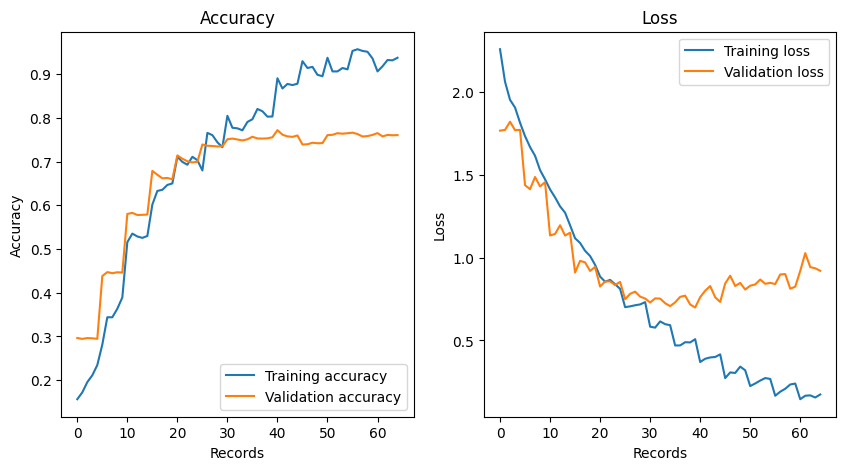

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(training_accuracy, label="Training accuracy")
axs[0].plot(validation_accuracy, label="Validation accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Records")
axs[0].set_ylabel("Accuracy")

axs[1].plot(training_loss, label="Training loss")
axs[1].plot(validation_loss, label="Validation loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")
axs[1].set_xlabel("Records")
axs[1].set_ylabel("Loss")

### Confusion matrix

In [63]:
def compute_confusion_matrix(model, testloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            _, pred = torch.max(output, dim=1)
            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return confusion_matrix(y_true, y_pred, normalize="true") * 100

In [64]:
conf_mat = compute_confusion_matrix(vgg, testloader)
print(conf_mat)

[[80.4  1.   4.9  1.4  2.   0.3  0.3  1.5  3.6  4.6]
 [ 0.6 87.7  0.1  0.6  0.5  0.2  0.1  0.2  0.9  9.1]
 [ 6.   0.1 66.   6.   9.4  4.5  3.7  2.6  0.7  1. ]
 [ 1.6  0.5  4.4 62.1  5.9 14.6  3.1  3.9  0.6  3.3]
 [ 1.5  0.4  4.5  5.9 75.4  2.8  2.4  6.6  0.1  0.4]
 [ 0.6  0.   3.5 21.6  3.3 62.9  0.6  6.2  0.3  1. ]
 [ 0.5  0.5  4.3 11.9  4.3  0.9 75.9  0.   0.8  0.9]
 [ 0.8  0.1  2.7  4.   4.3  3.   0.1 83.2  0.   1.8]
 [ 6.   2.9  1.7  2.   0.3  0.3  0.3  0.2 83.4  2.9]
 [ 2.1  3.6  0.2  0.7  0.2  0.   0.2  1.2  0.7 91.1]]


<Axes: >

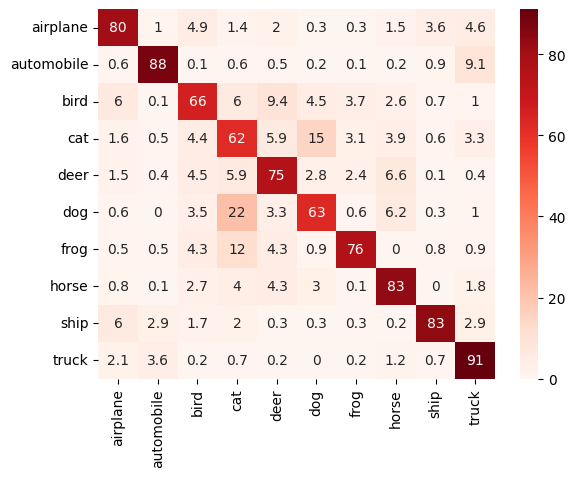

In [65]:
sns.heatmap(
    conf_mat, annot=True, cmap=cm.Reds, xticklabels=classes, yticklabels=classes
)

# Early exit

## B-NET

### Early exit decision criterion

In [66]:
def entropy(x):
    p = F.softmax(x.detach(), dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

### Model

In [67]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [68]:
class BVGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                e += 1
            if inference:
                # x is a single image, otherwise we would have to loop over the batch dimension
                H = entropy(x_ee)
                if torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        if inference:
            return x, H, e
        return out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Custom loss function

In [69]:
class JointCrossEntropy(nn.Module):
    def __init__(self):
        super(JointCrossEntropy, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = 0
        for output in outputs:
            loss += self.cross_entropy(output, targets)
        return loss

### Training loop

In [70]:
def train_model_ee(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [71]:
torch.manual_seed(42)
bvgg = BVGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee(
    bvgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.0945	Accuracy: [46.88 44.53 42.19 42.97 36.72 32.03 30.47 28.12 26.56 30.47]
Epoch 1	Training loss: 16.5083	Accuracy: [51.17 47.27 44.14 47.66 40.62 38.28 36.33 33.98 34.77 34.77]
Epoch 1	Training loss: 14.9897	Accuracy: [55.73 50.78 47.92 48.44 43.23 42.19 39.32 37.5  36.2  35.68]
Epoch 1	Training loss: 14.1618	Accuracy: [57.42 52.54 50.39 49.41 45.31 43.55 40.43 39.84 37.5  36.72]
Epoch 1	Training loss: 13.5151	Accuracy: [58.91 54.37 52.19 50.78 46.72 44.84 42.03 41.41 39.38 38.28]
Epoch 1	Validation loss: 12.3348	Accuracy: [70.31 67.19 72.66 67.97 61.72 60.94 62.5  59.38 55.47 50.78]
Epoch 1	Validation loss: 12.3999	Accuracy: [66.8  62.89 66.8  60.16 56.25 55.86 55.08 53.12 51.56 49.61]
Epoch 1	Validation loss: 12.6836	Accuracy: [66.15 61.98 65.62 59.9  57.29 55.21 54.69 51.82 51.3  48.96]
Epoch 1	Validation loss: 12.4910	Accuracy: [64.84 61.91 64.84 58.98 56.45 54.1  54.1  51.95 51.56 49.61]
Epoch 1	Validation loss: 12.6087	Accuracy: [63.91 61.72 64.38 57.

### Test data

In [74]:
# test accuracy
bvgg.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = bvgg(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

Exit 1 test accuracy: 68.37%
Test took 3.39 seconds
Exit 2 test accuracy: 74.99%
Test took 3.39 seconds
Exit 3 test accuracy: 76.33%
Test took 3.39 seconds
Exit 4 test accuracy: 76.55%
Test took 3.39 seconds
Exit 5 test accuracy: 77.99%
Test took 3.38 seconds
Exit 6 test accuracy: 79.18%
Test took 3.40 seconds
Exit 7 test accuracy: 79.58%
Test took 3.41 seconds
Exit 8 test accuracy: 79.80%
Test took 3.39 seconds
Exit 9 test accuracy: 79.68%
Test took 3.48 seconds
Exit 10 test accuracy: 79.36%
Test took 3.42 seconds


### Inference time

In [75]:
bvgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg.set_exit_threshold(0.1)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00154686 seconds
Exit: 2
Entropy: tensor([0.0001])
Output: tensor([[ -2.3211, -13.5246,  -2.8914,  -9.3414,  -4.2434,  -2.7765,  -8.9166,
          -6.5529,   7.7166,  -5.9606]])
Prediction: ship
Target: ship


### Learning curves.

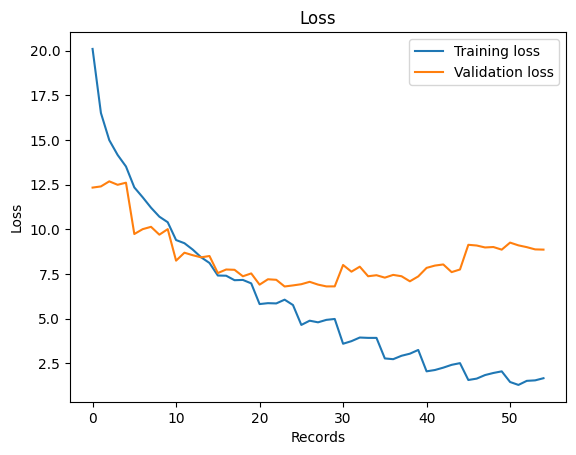

In [76]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


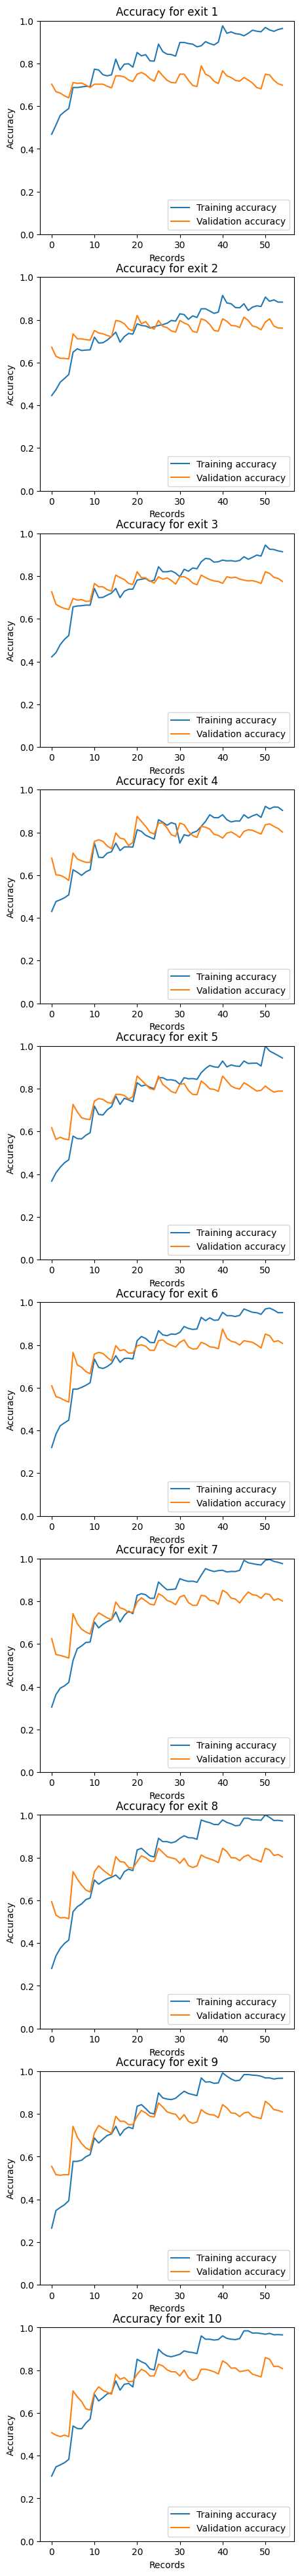

In [77]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

## Proposed algorithm for training

### Early exit decision criterion.

Based on:
- Entropy of the logits;
- Probability of the guess.

In [78]:
def entropy(x):
    p = F.softmax(x, dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

In [79]:
def find_max_prob(x):
    p = F.softmax(x, dim=1)
    return torch.max(p, dim=1).values

### Model

Function to create auxiliary branches in the network, based on the input shape of the image and the number of input channels (aka the depth of the feature map).

In [84]:
class BVGG13_v2(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v2, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        # create the early exit layers
        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                # evaluate the early exit
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                # compute the decision function
                H = entropy(x_ee)
                g_functions.append(H)
                e += 1
                # check if we can exit during inference phase
                if inference and torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # evaluate the final exit
        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        out.append(x)
        # compute the decision function
        last_H = entropy(x)
        # check if we can exit during inference phase
        if inference:
            return x, last_H, len(soft_out)

        # compute the soft-conditional output
        soft_out.append(x)

        # traverse the outputs in reverse order
        k = len(g_functions) - 1
        for o in out[-2::-1]:
            h = g_functions[k].unsqueeze(1)
            k -= 1
            f_tilde = h * o + (1 - h) * soft_out[-1]
            soft_out.append(f_tilde)

        soft_out.reverse()
        # training exit
        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Training loop

In [85]:
def train_model_ee_v2(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = model(data)
            # calculate the batch loss
            loss = loss_fn(soft_output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
            # break
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output, soft_output = model(data)
                loss = loss_fn(soft_output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)
        # break

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch}")
            if early_stop.restore_best_weights:
                print(f"Restored model trained at epoch {epoch - early_stop.counter}")
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [86]:
torch.manual_seed(42)
bvgg_v2 = BVGG13_v2(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v2.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v2.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v2,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.6050	Accuracy: [35.16 39.06 22.66 33.59 27.34 21.09 28.12 28.91 22.66 25.78]
Epoch 1	Training loss: 17.9081	Accuracy: [30.86 38.67 28.12 35.94 28.12 28.12 32.42 31.25 27.73 29.69]
Epoch 1	Training loss: 16.2535	Accuracy: [32.29 43.49 34.9  39.06 30.47 30.99 34.11 33.85 28.65 32.29]
Epoch 1	Training loss: 15.4908	Accuracy: [33.79 43.75 34.96 40.04 30.27 32.23 31.25 35.16 29.88 33.4 ]
Epoch 1	Training loss: 15.0091	Accuracy: [35.62 43.12 35.31 39.53 29.53 33.28 32.19 35.78 32.34 34.22]
Epoch 1	Validation loss: 14.3390	Accuracy: [46.88 53.12 46.09 45.31 27.34 35.16 45.31 46.88 42.19 42.19]
Epoch 1	Validation loss: 14.1711	Accuracy: [43.75 47.27 41.41 42.58 25.39 33.59 44.14 44.92 39.84 41.41]
Epoch 1	Validation loss: 14.7120	Accuracy: [42.71 46.09 41.67 42.45 27.6  32.55 43.49 44.27 39.58 41.41]
Epoch 1	Validation loss: 14.5275	Accuracy: [42.77 45.7  41.99 42.58 26.95 30.27 42.58 41.6  39.84 41.21]
Epoch 1	Validation loss: 14.4331	Accuracy: [42.66 43.75 41.25 41.

### Test data

In [87]:
# test accuracy
bvgg_v2.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v2(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

Exit 1 test accuracy: 23.91%
Test took 3.62 seconds
Exit 2 test accuracy: 17.97%
Test took 3.44 seconds
Exit 3 test accuracy: 23.79%
Test took 3.45 seconds
Exit 4 test accuracy: 10.00%
Test took 3.60 seconds
Exit 5 test accuracy: 32.42%
Test took 3.36 seconds
Exit 6 test accuracy: 36.76%
Test took 3.40 seconds
Exit 7 test accuracy: 44.36%
Test took 3.51 seconds
Exit 8 test accuracy: 68.37%
Test took 3.54 seconds
Exit 9 test accuracy: 69.17%
Test took 3.41 seconds
Exit 10 test accuracy: 77.68%
Test took 3.43 seconds


### Inference time

In [88]:
bvgg_v2.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v2.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v2(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00157189 seconds
Exit: 2
Entropy: tensor([0.0180])
Output: tensor([[-7.9487, -5.5792,  0.4518, -4.3725,  1.0438,  5.8483,  2.0177, -4.5421,
          9.0289, -0.5416]])
Prediction: ship
Target: ship


### Learning curves

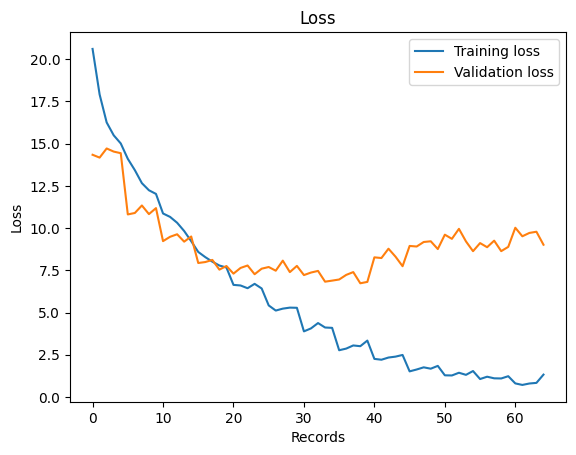

In [89]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(65, 10)


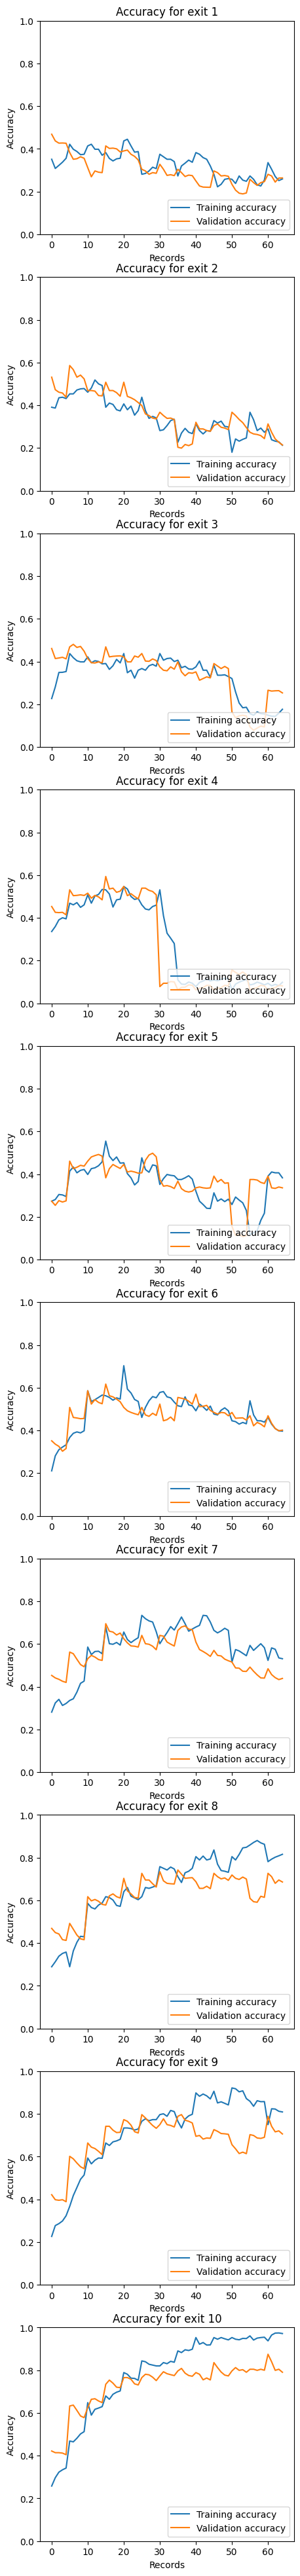

In [90]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

### Using a different decision criterion for early exit (probability of the output)

In [91]:
class BVGG13_v3(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v3, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                H = find_max_prob(x_ee)
                g_functions.append(H)
                e += 1
                if inference and torch.greater(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        last_H = find_max_prob(x)
        if inference:
            return x, last_H, len(soft_out)

        soft_out.append(x)

        k = len(g_functions) - 1
        for i, o in enumerate(out[-2::-1]):
            h = g_functions[k].unsqueeze(1)
            k -= 1
            # print(h.shape)
            # print(o.shape)
            f_tilde = h * o + (1 - h) * soft_out[-1]
            # print("Early exit", i)
            # print(f_tilde.detach().cpu())
            soft_out.append(f_tilde)

        soft_out.reverse()

        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [93]:
torch.manual_seed(42)
bvgg_v3 = BVGG13_v3(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v3.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v3.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v3,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.3849	Accuracy: [42.19 41.41 39.84 30.47 29.69 28.12 28.12 21.09 21.09 25.78]
Epoch 1	Training loss: 17.4711	Accuracy: [43.36 43.75 42.19 38.28 34.38 33.98 32.81 27.34 23.83 28.12]
Epoch 1	Training loss: 15.8367	Accuracy: [47.92 45.83 44.27 39.58 36.72 35.16 35.94 34.38 29.17 32.55]
Epoch 1	Training loss: 15.0849	Accuracy: [50.39 46.88 44.53 41.02 38.67 37.11 36.72 35.55 31.25 34.18]
Epoch 1	Training loss: 14.3262	Accuracy: [52.19 49.22 46.56 42.03 41.25 40.   40.16 39.53 33.75 36.88]
Epoch 1	Validation loss: 13.1327	Accuracy: [65.62 60.94 61.72 53.12 56.25 50.78 52.34 51.56 47.66 49.22]
Epoch 1	Validation loss: 13.0491	Accuracy: [63.28 57.03 56.64 51.56 49.61 50.   50.39 51.56 46.48 45.31]
Epoch 1	Validation loss: 13.4149	Accuracy: [63.54 57.03 56.77 52.08 51.56 50.52 50.   50.78 46.35 45.05]
Epoch 1	Validation loss: 13.1087	Accuracy: [62.7  55.47 55.86 50.98 51.17 51.37 50.78 50.2  47.07 45.12]
Epoch 1	Validation loss: 13.2671	Accuracy: [62.97 55.78 55.62 49.

### Test data

In [94]:
# test accuracy
bvgg_v3.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v3(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

Exit 1 test accuracy: 67.28%
Test took 3.45 seconds
Exit 2 test accuracy: 26.58%
Test took 3.45 seconds
Exit 3 test accuracy: 74.94%
Test took 3.43 seconds
Exit 4 test accuracy: 14.17%
Test took 3.45 seconds
Exit 5 test accuracy: 77.58%
Test took 3.45 seconds
Exit 6 test accuracy: 75.01%
Test took 3.46 seconds
Exit 7 test accuracy: 78.52%
Test took 3.45 seconds
Exit 8 test accuracy: 78.86%
Test took 3.46 seconds
Exit 9 test accuracy: 79.21%
Test took 3.46 seconds
Exit 10 test accuracy: 79.05%
Test took 3.44 seconds


### Inference time

In [98]:
bvgg_v3.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v3.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v3(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Probability: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00498939 seconds
Exit: 2
Probability: tensor([0.9993])
Output: tensor([[ 1.7331, -7.7804,  0.4006, -4.4129, -0.4069, -1.5745, -6.8157, -1.5326,
          9.4581, -2.0756]])
Prediction: ship
Target: ship


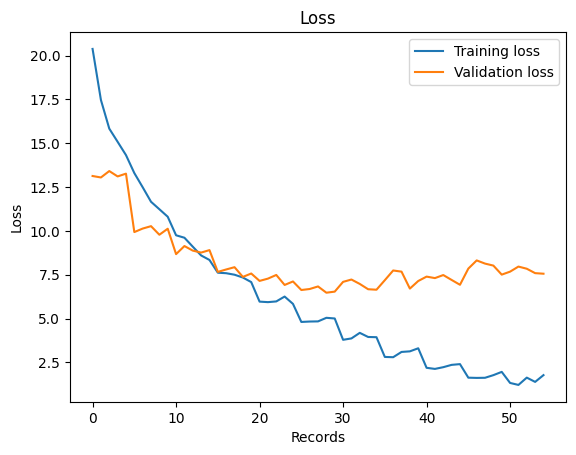

In [96]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


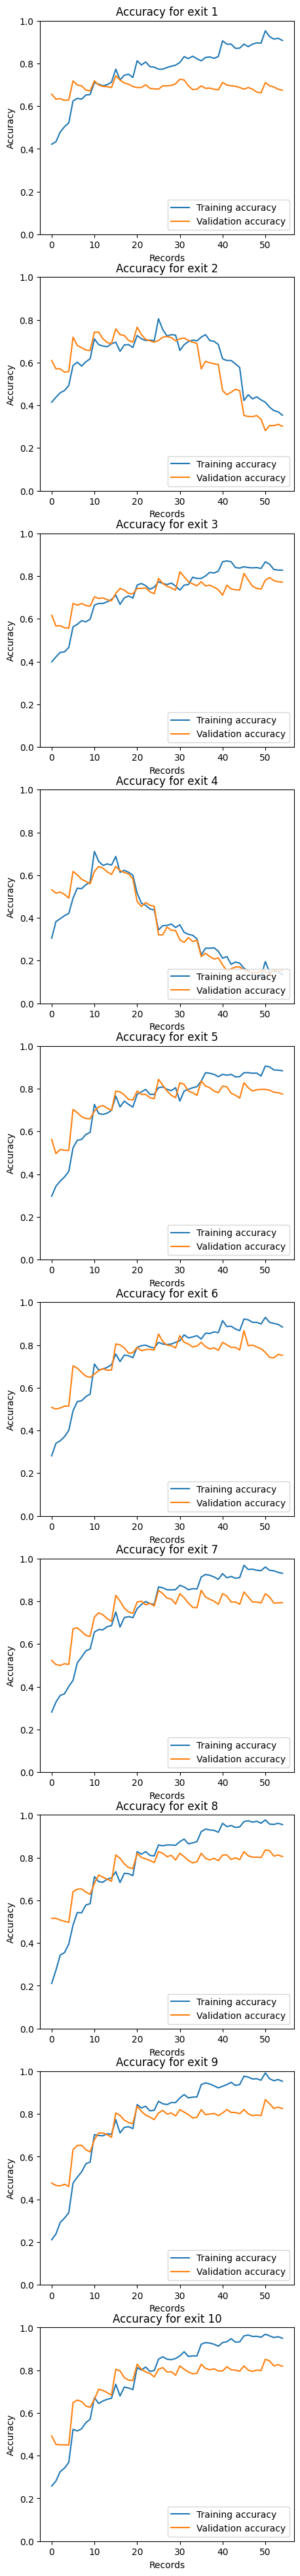

In [97]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])